In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adams
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt

In [6]:
# Disable oneDNN optimizations to avoid numerical differences
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [7]:
# Load and preprocess the CIFAR-10 dataset
(train_X, train_Y), (test_X, test_Y) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [8]:
train_X.shape

(50000, 32, 32, 3)

In [9]:
# Normalize pixel values to the range [0, 1]
train_X = train_X.astype('float32') / 255.0
test_X = test_X.astype('float32') / 255.0

In [10]:
train_X

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]

In [11]:
# Convert labels to one-hot encoded format (ensure this is done only once)
num_classes = 10
train_Y = tf.keras.utils.to_categorical(train_Y, num_classes)
test_Y = tf.keras.utils.to_categorical(test_Y, num_classes)


In [12]:
# Verify the shapes to ensure correctness
print(f"train_X shape: {train_X.shape}, train_Y shape: {train_Y.shape}")
print(f"test_X shape: {test_X.shape}, test_Y shape: {test_Y.shape}")

train_X shape: (50000, 32, 32, 3), train_Y shape: (50000, 10)
test_X shape: (10000, 32, 32, 3), test_Y shape: (10000, 10)


In [13]:
test_Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [14]:
# Enhanced data augmentation for better generalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.3,
    shear_range=0.15,
    fill_mode='nearest'
)
datagen.fit(train_X)

In [15]:
# Redesign the CNN model for better performance on CIFAR-10
model = Sequential()
# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same') )
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Dense layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,358,666 (20.44 MB)

 Trainable params: 5,354,826 (20.43 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [17]:
# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [18]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)



In [19]:
# Train the model with data augmentation and callbacks
batch_size = 32
epochs = 100
history = model.fit(
    datagen.flow(train_X, train_Y, batch_size=batch_size),
    epochs=epochs,
    validation_data=(test_X, test_Y),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - accuracy: 0.2980 - loss: 2.3289 - val_accuracy: 0.4739 - val_loss: 1.5254 - learning_rate: 0.0010
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.4792 - loss: 1.4907 - val_accuracy: 0.5788 - val_loss: 1.2114 - learning_rate: 0.0010
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.5630 - loss: 1.2442 - val_accuracy: 0.5004 - val_loss: 1.7325 - learning_rate: 0.0010
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.6176 - loss: 1.0971 - val_accuracy: 0.6461 - val_loss: 1.0567 - learning_rate: 0.0010
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.6453 - loss: 1.0207 - val_accuracy: 0.6791 - val_loss: 1.0186 - learning_rate: 0.0010
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.6732 - loss: 0.9463 - val_accuracy: 0.7379 - val_loss: 0.7845 - learning_rate: 0.0010
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step -

In [20]:
# Evaluate the model
_, acc = model.evaluate(test_X, test_Y, verbose=0)
print(f"Test Accuracy: {acc*100:.2f}%")

Test Accuracy: 90.68%


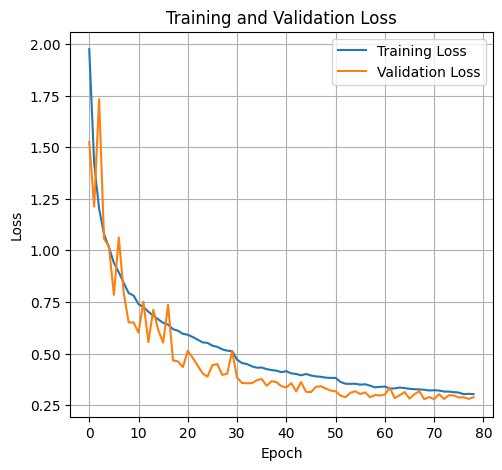

In [21]:
# Plot training & validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
#plt.savefig('loss_plot.png')

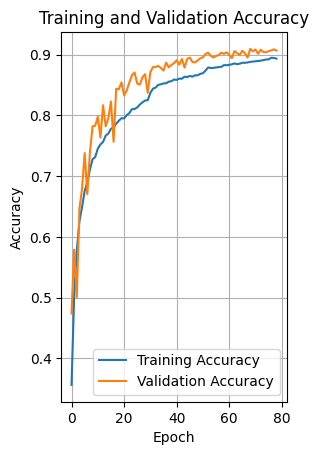

In [22]:
# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
#plt.savefig('accuracy_plot.png')

In [23]:
# Save the improved model
model.save("model1_cifar_improved.h5")

In [24]:
pip install streamlit tensorflow pillow numpy

In [25]:
#GUI for predict image

import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

# Define CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load the trained model
model = tf.keras.models.load_model('model1_cifar_improved.h5')

# Function to preprocess the uploaded image
def preprocess_image(image):
    # Resize image to 32x32 (CIFAR-10 input size)
    image = image.resize((32, 32))
    # Convert image to numpy array
    image_array = np.array(image)
    # Ensure the image has 3 channels (RGB)
    if image_array.shape[-1] != 3:
        image_array = np.stack((image_array,) * 3, axis=-1) if len(image_array.shape) == 2 else image_array
    # Normalize pixel values to [0, 1]
    image_array = image_array.astype('float32') / 255.0
    # Add batch dimension (1, 32, 32, 3)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Streamlit UI
st.title("CIFAR-10 Image Classification")
st.write("Upload an image to classify it into one of the 10 CIFAR-10 categories.")

# File uploader for image
uploaded_file = st.file_uploader("/content/drive/MyDrive/Colab Notebooks/bird.jpg", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Load and display the uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Preprocess the image
    processed_image = preprocess_image(image)

    # Make prediction
    predictions = model.predict(processed_image)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx] * 100

    # Display prediction
    st.write(f"**Predicted Class**: {predicted_class}")
    st.write(f"**Confidence**: {confidence:.2f}%")

    # Display confidence scores for all classes
    st.write("**Confidence Scores for All Classes**:")
    for i, class_name in enumerate(class_names):
        st.write(f"{class_name}: {predictions[0][i]*100:.2f}%")

2025-05-08 08:28:50.241 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 08:28:50.557 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-08 08:28:50.569 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 08:28:50.570 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 08:28:50.571 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 08:28:50.572 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 08:28:50.574 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 08:28:50.575 Thread 'MainThread': mi

In [ ]:
# Without GUI show prediction
import tensorflow as tf
import numpy as np
from PIL import Image

# Define CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load the trained model
try:
    model = tf.keras.models.load_model('model1_cifar_improved.h5')
except Exception as e:
    print(f"Error loading model: {e}")
    exit(1)

# Function to preprocess the image
def preprocess_image(image_path):
    # Load and resize image to 32x32 (CIFAR-10 input size)
    image = Image.open(image_path).resize((32, 32))
    # Convert image to numpy array
    image_array = np.array(image)
    # Ensure the image has 3 channels (RGB)
    if len(image_array.shape) == 2:  # Grayscale image
        image_array = np.stack((image_array,) * 3, axis=-1)
    elif image_array.shape[-1] == 4:  # RGBA image
        image_array = image_array[..., :3]  # Drop alpha channel
    # Normalize pixel values to [0, 1]
    image_array = image_array.astype('float32') / 255.0
    # Add batch dimension (1, 32, 32, 3)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Function to predict the class of an image
def predict_image(image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path)
    # Make prediction
    predictions = model.predict(processed_image)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx] * 100
    return predicted_class, confidence, predictions[0]

# Main execution
def main():
    while True:
        # Prompt user for image path
        print("\nPlease enter the path to the image file (e.g., 'image.jpg'):")
        image_path = input().strip()

        try:
            # Predict the class
            predicted_class, confidence, all_confidences = predict_image(image_path)

            # Print results
            print(f"\nPredicted Class: {predicted_class}")
            print(f"Confidence: {confidence:.2f}%")
            print("\nConfidence Scores for All Classes:")
            for i, class_name in enumerate(class_names):
                print(f"{class_name}: {all_confidences[i]*100:.2f}%")

        except Exception as e:
            print(f"Error processing image: {e}")
            print("Please try again with a valid image path.")
            continue

        # Prompt user for next action
        print("\nEnter 0 to predict another image, or 1 to exit:")
        user_choice = input().strip()

        # Handle user choice
        if user_choice == '1':
            print("Exiting the program. Goodbye!")
            break
        elif user_choice != '0':
            print("Invalid input. Please enter 0 to continue or 1 to exit.")
            continue
        # If user enters 0, the loop continues and prompts for another image path

if __name__ == "__main__":
    main()


Please enter the path to the image file (e.g., 'image.jpg'):
/content/drive/MyDrive/Colab Notebooks/ship.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step

Predicted Class: ship
Confidence: 99.96%

Confidence Scores for All Classes:
airplane: 0.04%
automobile: 0.00%
bird: 0.00%
cat: 0.00%
deer: 0.00%
dog: 0.00%
frog: 0.00%
horse: 0.00%
ship: 99.96%
truck: 0.00%

Enter 0 to predict another image, or 1 to exit:
/content/drive/MyDrive/Colab Notebooks/bird.jpg
Invalid input. Please enter 0 to continue or 1 to exit.

Please enter the path to the image file (e.g., 'image.jpg'):
/content/drive/MyDrive/Colab Notebooks/bird.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Predicted Class: bird
Confidence: 99.96%

Confidence Scores for All Classes:
airplane: 0.02%
automobile: 0.00%
bird: 99.96%
cat: 0.00%
deer: 0.00%
dog: 0.00%
frog: 0.00%
horse: 0.01%
ship: 0.00%
truck: 0.00%

Enter 0 to predict another image, or 1 to exit:
/content/drive/MyDrive/Colab Notebooks/frog.jpg
Invalid input. Please enter 0 to co